![](files/Fasshauer.png)

In [1]:
using SpecialFunctions, Laplacians, KernelMatrices, LinearAlgebra, Plots

function dist(x, z, d = 2)
    return (sum((x .- z).^d))^(1/d)
end

function matkern(dis::Number, epsilon::Number, m::Number, d::Int = 2)
    if dis == 0.0 
        return 1.0
    else
        return besselk(m-d/2, epsilon*dis)*(epsilon*dis)^(m-d/2)
    end
end

matkern (generic function with 2 methods)

[103, 134, 135, 136, 165, 166, 167, 168, 169, 186, 198, 199, 200, 217, 218, 219, 231, 246, 248, 249, 250, 251, 252, 277, 278, 279, 281, 282, 283, 303, 308, 309, 310, 311, 312, 314, 334, 335, 336, 341, 342, 343, 365, 366, 367, 368, 369, 374, 398, 399, 400, 431]
There are 52 missing.


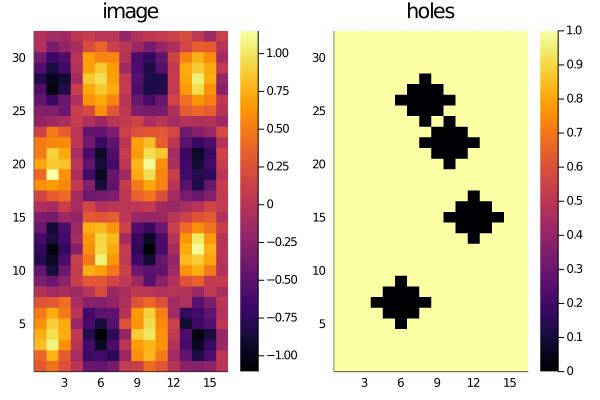

In [2]:
L = 32
K = 16
a_num = (L,K) # length vectors for a 2D problem
x1 = 1:a_num[1]
x2 = 1:a_num[2]
d = length(a_num)
img = sin.(2*pi*x1/16)*sin.(2*pi*x2'/8) + randn(a_num)*0.1


cent = [(7,6), (15,12), (22,10), (26, 8)]
rad = 2.0

function prod_dot(m)
    mas = m[1]
    for i = 2:length(m)
        mas .*= m[i]
    end
    return mas
end

mask = map(c->broadcast(+, (x1 .- c[1]).^2, (x2 .- c[2])'.^2) .> rad^2, cent)
mask = prod_dot(mask)

# Find where the data are missing
inds = sortperm(mask[:])
S = L*K-sum(mask)
missing_inds = inds[1:S]
println(missing_inds)
nonmissing_inds = inds[(S+1):end]

println("There are $S missing.")

p1 = heatmap(img, title = "image")
p2 = heatmap(mask, title = "holes")

plot(p1,p2,layout=(1,2))

From Rasmussen and Williams book:
![](files/RW_GP_Pred.png)

In [3]:
# No noise is assumed, sigsq_n = 0

xx = [[x,y] for x in x1 for y in x2]
xxyy = [(x,y) for x in xx[inds] for y in xx[inds]]
dis = reshape(map(x -> dist(x...), xxyy), (512, 512))

epsilon = 0.22
m = 2
M = matkern.(dis, epsilon, m)

chK = cholesky(M[nonmissing_inds, nonmissing_inds])
alpha = chK.L'\(chK.L\img[nonmissing_inds])
fbar = M[nonmissing_inds,missing_inds]'*alpha

52-element Array{Float64,1}:
  0.03877872985416175
 -0.22980404035305568
 -0.12237001212201548
  0.06064843086131333
 -0.8533693703208094
 -0.6203375061346641
 -0.25778386788539365
  0.11138900597845236
  0.4648109411526349
  0.8350375374277661
  0.25546446977574533
  0.4951554899858124
  0.2958490544045631
  ⋮
  0.2795446432692046
  0.2023471579664715
 -0.1534201489299818
 -0.20810472020508541
 -0.2655974886874475
 -0.565437266957872
 -0.5723906127174843
 -0.20821432424609299
  0.435260873108426
  0.30996296131929313
  0.17458172111027892
  0.6644064301848474

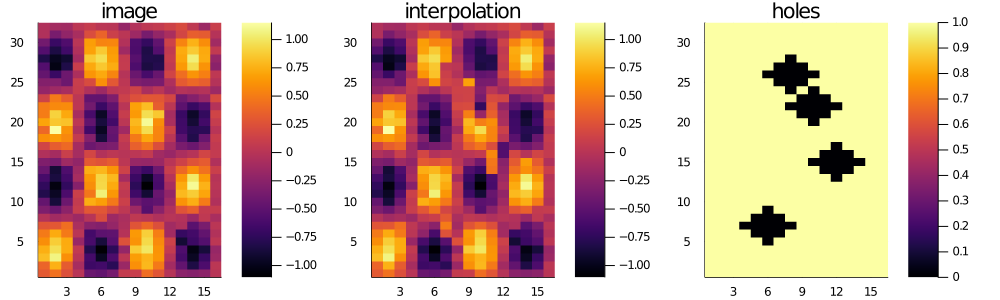

In [4]:
img_int = copy(img)
img_int[missing_inds] = fbar

p3 = heatmap(img_int, title="interpolation")

plot(p1,p3,p2,layout=(1,3),size=(1000,300))

In [5]:
hcat(img[missing_inds], fbar)

52×2 Array{Float64,2}:
 -0.0732669     0.0387787
 -0.640598     -0.229804
 -0.267964     -0.12237
 -0.000988131   0.0606484
 -0.874852     -0.853369
 -0.51133      -0.620338
 -0.298301     -0.257784
  0.217454      0.111389
  0.282207      0.464811
  0.719162      0.835038
 -0.495725      0.255464
 -0.199061      0.495155
 -0.156068      0.295849
  ⋮            
  0.330843      0.279545
  0.284956      0.202347
 -0.0082095    -0.15342
  0.0952999    -0.208105
  0.00919745   -0.265597
 -0.177003     -0.565437
 -0.110321     -0.572391
  0.0262944    -0.208214
  0.398476      0.435261
  0.133921      0.309963
 -0.0717206     0.174582
  0.26138       0.664406